In [165]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [166]:
sox_data = yf.download("^SOX", start="2022-06-29", end="2024-06-27", interval="1d")
print(sox_data.head(20))
print(len(sox_data))

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-06-29  2604.979980  2610.679932  2553.530029  2583.979980  2583.979980   
2022-06-30  2548.639893  2602.550049  2514.419922  2556.250000  2556.250000   
2022-07-01  2512.100098  2524.030029  2429.899902  2458.459961  2458.459961   
2022-07-05  2391.810059  2478.260010  2386.669922  2477.639893  2477.639893   
2022-07-06  2477.320068  2520.830078  2456.229980  2494.110107  2494.110107   
2022-07-07  2560.199951  2616.439941  2555.379883  2605.889893  2605.889893   
2022-07-08  2567.179932  2632.340088  2561.280029  2618.020020  2618.020020   
2022-07-11  2575.739990  2588.020020  2538.979980  2553.689941  2553.689941   
2022-07-12  2583.219971  2588.379883  2542.540039  2558.169922  2558.169922   
2022-07-13  2507.850098  2594.969971  2504.989990  2577.360107  2577.360107   
2022-07-14  2566.739990  2636.629883  2529.550049  2

In [167]:
file_path = '/Users/aliceteng/Downloads/testData.xlsx'
data = pd.read_excel(file_path)
data['date'] = data['datetime'].dt.date
data['time'] = data['datetime'].dt.time
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S').dt.time
data.head(30)

,datetime,open,high,low,close,volume,date,time
0,2022-07-01 08:45:00,14656,14702,14512,14566,27167,2022-07-01,08:45:00
1,2022-07-01 09:15:00,14567,14622,14493,14520,21725,2022-07-01,09:15:00
2,2022-07-01 09:45:00,14520,14568,14476,14538,16847,2022-07-01,09:45:00
3,2022-07-01 10:15:00,14539,14549,14380,14386,19716,2022-07-01,10:15:00
4,2022-07-01 10:45:00,14388,14403,14281,14288,23082,2022-07-01,10:45:00
5,2022-07-01 11:15:00,14288,14319,14226,14238,16337,2022-07-01,11:15:00
6,2022-07-01 11:45:00,14239,14320,14230,14246,13369,2022-07-01,11:45:00
7,2022-07-01 12:15:00,14246,14274,14211,14237,10962,2022-07-01,12:15:00
8,2022-07-01 12:45:00,14235,14243,14181,14184,10873,2022-07-01,12:45:00
9,2022-07-01 13:15:00,14184,14194,14128,14175,23531,2022-07-01,13:15:00


In [168]:
data_mor = data[(data['time'] >= pd.to_datetime('08:45:00').time()) & (data['time'] <= pd.to_datetime('13:15:00').time())]
date_list = []
open_list = []
high_list = []
low_list = []
close_list = []
volume_list = []

for i in range(0, len(data_mor), 10):
    chunk = data_mor.iloc[i:i+10]
    date_list.append(chunk['date'].iloc[0])
    open_list.append(chunk['open'].iloc[0])
    high_list.append(chunk['high'].max())
    low_list.append(chunk['low'].min())
    close_list.append(chunk['close'].iloc[-1])
    volume_list.append(chunk['volume'].sum())

daily_data = pd.DataFrame({'Date': date_list, 'Open': open_list, 'High': high_list, 'Low': low_list, 'Close': close_list, 'Volume': volume_list})
daily_data.set_index('Date', inplace=True)

print(daily_data.head(20))
print(len(daily_data))

             Open   High    Low  Close  Volume
Date                                          
2022-07-01  14656  14702  14128  14175  183609
2022-07-04  14236  14312  14025  14152  143166
2022-07-05  14350  14430  13975  14231  174925
2022-07-06  14213  14239  13858  13871  150634
2022-07-07  14068  14295  13832  14176  157844
2022-07-08  14390  14485  14264  14329  139163
2022-07-11  14467  14496  14229  14276  119884
2022-07-12  14157  14181  13850  13914  126970
2022-07-13  14240  14356  14203  14277  112280
2022-07-14  14237  14437  14122  14389  128056
2022-07-15  14422  14542  14333  14475  115586
2022-07-18  14577  14666  14535  14650   97507
2022-07-19  14562  14697  14533  14678   75051
2022-07-20  14845  14907  14577  14616   67636
2022-07-21  14600  14771  14573  14748   90727
2022-07-22  14796  14848  14725  14751   90996
2022-07-25  14750  14845  14688  14794   82634
2022-07-26  14755  14788  14650  14705   92181
2022-07-27  14670  14800  14615  14794  104595
2022-07-28  1

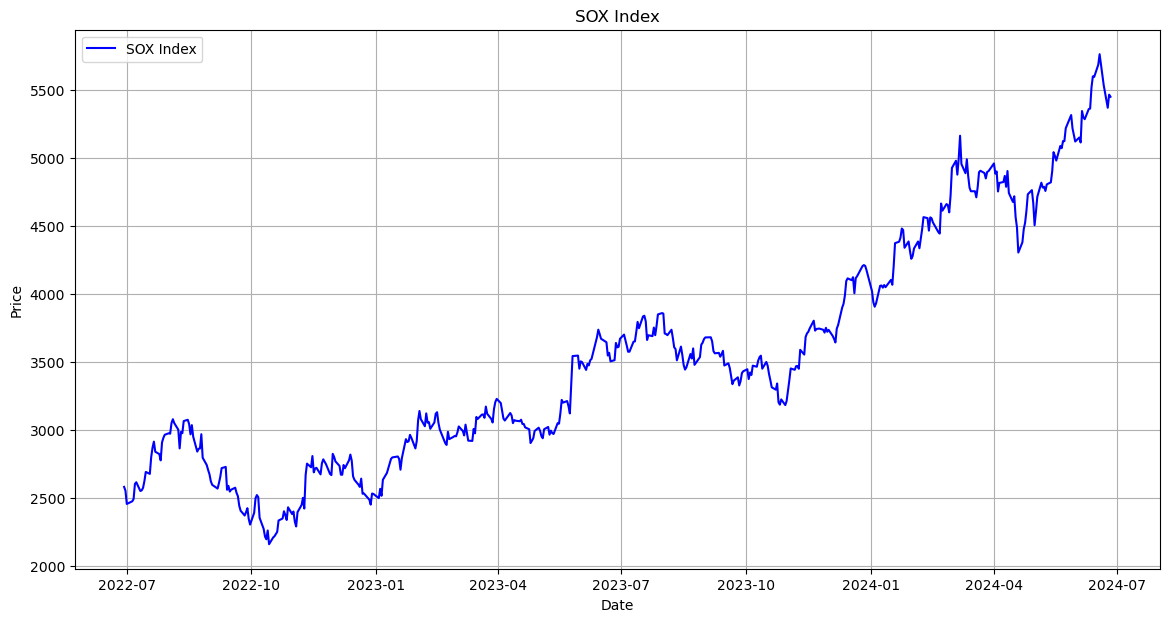

In [169]:
plt.figure(figsize=(14, 7))
plt.plot(sox_data['Close'], label='SOX Index', color='blue')
plt.title('SOX Index')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

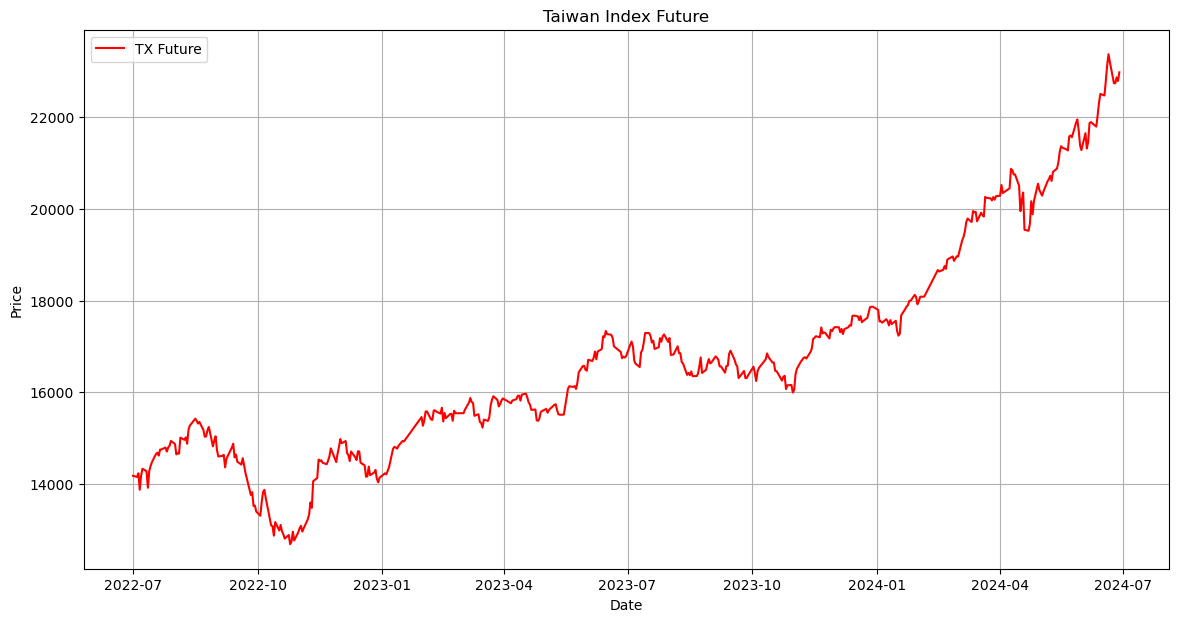

In [170]:
plt.figure(figsize=(14, 7))
plt.plot(daily_data['Close'], label='TX Future', color='red')
plt.title('Taiwan Index Future')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

In [171]:
date_series = pd.to_datetime(date_list)
previous_day_series = date_series - pd.Timedelta(days=1)
previous_business_days = [date - pd.offsets.BDay(1) for date in date_series]
previous_business_days_str = [date.strftime('%Y-%m-%d') for date in previous_business_days]
print(previous_business_days_str)

['2022-06-30', '2022-07-01', '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-09', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-10', '2022

In [172]:
all_dates = pd.DataFrame(index=pd.to_datetime(previous_business_days_str))
sox_predate = all_dates.join(sox_data, how='left')
sox_predate = sox_predate.rename(columns={'Open': 'S-Open', 'High': 'S-High', 'Low': 'S-Low', 'Close': 'S-Close'})
print(sox_predate)

                 S-Open       S-High        S-Low      S-Close    Adj Close  \
2022-06-30  2548.639893  2602.550049  2514.419922  2556.250000  2556.250000   
2022-07-01  2512.100098  2524.030029  2429.899902  2458.459961  2458.459961   
2022-07-04          NaN          NaN          NaN          NaN          NaN   
2022-07-05  2391.810059  2478.260010  2386.669922  2477.639893  2477.639893   
2022-07-06  2477.320068  2520.830078  2456.229980  2494.110107  2494.110107   
...                 ...          ...          ...          ...          ...   
2024-06-21  5538.149902  5613.470215  5482.450195  5538.540039  5538.540039   
2024-06-24  5485.180176  5519.399902  5369.560059  5371.520020  5371.520020   
2024-06-25  5413.049805  5470.270020  5361.810059  5467.660156  5467.660156   
2024-06-26  5469.649902  5499.410156  5389.479980  5452.319824  5452.319824   
2024-06-27          NaN          NaN          NaN          NaN          NaN   

            Volume  
2022-06-30     0.0  
2022-07-0

In [173]:
f_close = daily_data['Close'].to_list()
s_close = sox_predate['S-Close'].to_list()
merged_df = pd.DataFrame({'Date': date_list, 'F-Close': f_close, 'S-Date': previous_business_days_str, 'S-Close': s_close})
comparison = merged_df.dropna()
print(comparison.head(20))
future_price = pd.Series(comparison['F-Close'])
sox_price = pd.Series(comparison['S-Close'])
correlation = future_price.corr(sox_price)
print(f'SOX & Future Correlation: {correlation}')

          Date  F-Close      S-Date      S-Close
0   2022-07-01    14175  2022-06-30  2556.250000
1   2022-07-04    14152  2022-07-01  2458.459961
3   2022-07-06    13871  2022-07-05  2477.639893
4   2022-07-07    14176  2022-07-06  2494.110107
5   2022-07-08    14329  2022-07-07  2605.889893
6   2022-07-11    14276  2022-07-08  2618.020020
7   2022-07-12    13914  2022-07-11  2553.689941
8   2022-07-13    14277  2022-07-12  2558.169922
9   2022-07-14    14389  2022-07-13  2577.360107
10  2022-07-15    14475  2022-07-14  2626.919922
11  2022-07-18    14650  2022-07-15  2693.770020
12  2022-07-19    14678  2022-07-18  2679.570068
13  2022-07-20    14616  2022-07-19  2803.139893
14  2022-07-21    14748  2022-07-20  2872.959961
15  2022-07-22    14751  2022-07-21  2916.810059
16  2022-07-25    14794  2022-07-22  2842.409912
17  2022-07-26    14705  2022-07-25  2825.030029
18  2022-07-27    14794  2022-07-26  2778.959961
19  2022-07-28    14831  2022-07-27  2911.000000
20  2022-07-29    14

In [174]:
sox_change = sox_data['Close'].pct_change().shift(1).dropna()
sox_change_df = pd.DataFrame(sox_change)
sox_change_df.reset_index(inplace=True)
sox_change_df.rename(columns={'index': 'Date'}, inplace=True)
sox_change_df.rename(columns={'Close': 'Change'}, inplace=True)
sox_change_df

,Date,Change
0,2022-07-01,-0.010731
1,2022-07-05,-0.038255
2,2022-07-06,0.007802
3,2022-07-07,0.006648
4,2022-07-08,0.044818
...,...,...
494,2024-06-20,0.013541
495,2024-06-21,-0.026905
496,2024-06-24,-0.012740
497,2024-06-25,-0.030156


In [175]:
comparison['Date'] = pd.to_datetime(comparison['Date'])
sox_change_df['Date'] = pd.to_datetime(sox_change_df['Date'])
calculation = pd.merge(comparison, sox_change_df, on='Date', how='left').fillna(0)
calculation.head(60)


/var/folders/8p/ng1_5twx54scf45s9sw1xlgc0000gn/T/ipykernel_47740/355630938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison['Date'] = pd.to_datetime(comparison['Date'])


,Date,F-Close,S-Date,S-Close,Change
0,2022-07-01,14175,2022-06-30,2556.250000,-0.010731
1,2022-07-04,14152,2022-07-01,2458.459961,0.000000
2,2022-07-06,13871,2022-07-05,2477.639893,0.007802
3,2022-07-07,14176,2022-07-06,2494.110107,0.006648
4,2022-07-08,14329,2022-07-07,2605.889893,0.044818
5,2022-07-11,14276,2022-07-08,2618.020020,0.004655
6,2022-07-12,13914,2022-07-11,2553.689941,-0.024572
7,2022-07-13,14277,2022-07-12,2558.169922,0.001754
8,2022-07-14,14389,2022-07-13,2577.360107,0.007502
9,2022-07-15,14475,2022-07-14,2626.919922,0.019229


In [176]:
data_mor.tail(20)
data_mor.to_excel("/Users/aliceteng/Downloads/data_mor.xlsx")

In [177]:
initial_capital = 100000000
slippage = 0.001
commission = 50
tax_rate = 0.00002
unit_dollar = 200

In [178]:
calculation['Date'] = pd.to_datetime(sox_change_df['Date']).dt.date
data_mor['date'] = pd.to_datetime(data_mor['date']).dt.date

/var/folders/8p/ng1_5twx54scf45s9sw1xlgc0000gn/T/ipykernel_47740/1365416050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mor['date'] = pd.to_datetime(data_mor['date']).dt.date


In [179]:
Condition = None
t = 0
stop_profit_point = 400
stop_loss_point = 200
date_list = []
entry_price_list = []

trade_df = pd.DataFrame(columns=['Entry Datetime', 'Original Price', 'Condition', 'Entry Price', 'Amount', 'Exit Datetime', 'Exit Price', 'Trade Profit', 'Net Profit', 'Trade Return',])

for i in range(0, len(data_mor) - 9, 10):
    change_series = calculation.loc[calculation['Date'] == data_mor['date'].iloc[i], 'Change']
    
    if not change_series.empty:
        change = change_series.values[0]
    else:
        change = 0

    k = i + 1
    
    if change > 0:
        Condition = 'B'
        entry_datetime = data_mor['datetime'].iloc[k]
        original_price = data_mor['open'].iloc[k]
        entry_price = data_mor['open'].iloc[k] * (1 + slippage)
        amount = ((initial_capital * 0.05) // (entry_price * unit_dollar))
        
        for j in range(k, k + 9):
            if data_mor['high'].iloc[j] >= entry_price + stop_profit_point:
                exit_price = entry_price + stop_profit_point
                exit_datetime = data_mor['datetime'].iloc[j]
                break
            elif data_mor['low'].iloc[j] <= entry_price - stop_loss_point:
                exit_price = entry_price - stop_loss_point
                exit_datetime = data_mor['datetime'].iloc[j]
                break
            elif j == k + 8:
                exit_price = data_mor['open'].iloc[j] *(1 - slippage)
                exit_datetime = data_mor['datetime'].iloc[j]
        trade_profit = (exit_price - entry_price) * unit_dollar * amount
        net_profit = trade_profit - commission - (exit_price + entry_price) * unit_dollar * tax_rate
        trade_return = (net_profit / (entry_price * unit_dollar * amount))
        new_row = {'Entry Datetime' : entry_datetime, 'Original Price' : original_price, 'Condition' : Condition, 
                   'Entry Price' : entry_price, 'Amount': amount, 'Exit Datetime': exit_datetime, 
                   'Exit Price': exit_price, 'Trade Profit': trade_profit, 'Net Profit': net_profit, 
                   'Trade Return': trade_return}
        new_row_df = pd.DataFrame([new_row])
        trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
        Condition = None
    
    elif change < 0:
        Condition = 'S'
        entry_datetime = data_mor['datetime'].iloc[k]
        original_price = data_mor['open'].iloc[k]
        entry_price = data_mor['open'].iloc[k] * (1 - slippage)
        amount = ((initial_capital * 0.2) // (entry_price * unit_dollar))
        exit_price = None
        exit_datetime = None
        
        for j in range(k, k + 9):
            if data_mor['low'].iloc[j] <= entry_price - stop_profit_point:
                exit_price = entry_price - stop_profit_point
                exit_datetime = data_mor['datetime'].iloc[j]
                break
            elif data_mor['high'].iloc[j] >= entry_price + stop_loss_point:
                exit_price = entry_price + stop_loss_point
                exit_datetime = data_mor['datetime'].iloc[j]
                break
            elif j == k + 8:
                exit_price = data_mor['open'].iloc[j] *(1 + slippage)
                exit_datetime = data_mor['datetime'].iloc[j]
        
        trade_profit = (entry_price - exit_price) * unit_dollar * amount
        net_profit = trade_profit - commission - (exit_price + entry_price) * unit_dollar * tax_rate
        trade_return = (net_profit / (entry_price * unit_dollar * amount))
        new_row = {'Entry Datetime' : entry_datetime, 'Original Price' :original_price, 'Condition' : Condition, 
                   'Entry Price' : entry_price, 'Amount': amount, 'Exit Datetime': exit_datetime, 
                   'Exit Price': exit_price, 'Trade Profit': trade_profit, 'Net Profit': net_profit, 
                   'Trade Return': trade_return}
        new_row_df = pd.DataFrame([new_row])
        trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
        Condition = None
    
trade_df.to_excel("/Users/aliceteng/Downloads/trade_record.xlsx")
print(trade_df['Net Profit'].sum())

/var/folders/8p/ng1_5twx54scf45s9sw1xlgc0000gn/T/ipykernel_47740/227955284.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)


-7188503.410199561
